In [2]:
import sys
sys.path.append("..") # This is for the imports from adjacent folders to work

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 200

from main_functions.DCv5_parallel_doubly_stretched import get_circuit as problem_circuit
#from main_functions.DCv5_multiple_XY4 import get_circuit as problem_circuit
from main_functions.gen_dynamic_circuit_v5 import get_circuit as test_circuit
from main_functions.solve_diagonal_ME import solve_diag_ME
from qiskit_aer import AerSimulator
from qiskit import generate_preset_pass_manager
from qiskit.circuit import IfElseOp
from qiskit_ibm_runtime import Batch, SamplerV2
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService

import pickle
import json
import math
import random
from utils.isa_cdr import generate_isa_clifford_circuits, get_populations, train_model, correct_observable
from utils.get_worst_case_trotter_schedule import get_worst_case_trotter_schedule
from utils.generate_complementary_colors import generate_complementary_colors

c:\Users\Benjamin\iCloudDrive\PhD\Projects\Efficient modeling of dissipative dynamics using quantum circuits\GitHub repository\dissipative_dynamics\tests\..\main_functions\DCv5_parallel_doubly_stretched.py:20: SyntaxWarning: invalid escape sequence '\o'
  """
c:\Users\Benjamin\iCloudDrive\PhD\Projects\Efficient modeling of dissipative dynamics using quantum circuits\GitHub repository\dissipative_dynamics\tests\..\main_functions\gen_dynamic_circuit_v5.py:19: SyntaxWarning: invalid escape sequence '\o'
  """


In [3]:
QiskitRuntimeService.save_account( 
 token="ryeQLJCCBlp2Y1CK7B0KvXRUvVDG7Xbkhu8H2L9MXUsU", 
 channel="ibm_cloud",
 instance='crn:v1:bluemix:public:quantum-computing:us-east:a/5fef03c739244d07801bbb0cd3b5d388:4854b5b3-784b-48cc-8949-0fe8c86aa28b::', 
 name="quantum_credits",
 overwrite=True
 )

service = QiskitRuntimeService(name="quantum_credits")

In [7]:
num_emitters = 5
omega_m = [1.2]*num_emitters
omega_c = 1.1
gamma = [0.8*10**(-6)]*num_emitters
kappa = [0.2]
g = [0.03]*(2*(num_emitters-1)) 
t = 200*(np.linspace(0, 1, 5)**1.5)
initial_state = ['1', '3']

samples = 10**2
noisy_backend = service.backend("ibm_kingston")
optimization_level = 2
shots = 4*(0.5*10**4)
options = {
    "default_shots": shots
    # "twirling": {
    #     "enable_gates": True,
    #     "enable_measure": False,
    #     "num_randomizations": "auto",
    #     "shots_per_randomization": "auto"
    # }
}

Before transpiling, we will first run different Trotterizations of the circuit, as well as the QuTiP exact solution and pass then to the `get_worse_case_trotter_schedule` to get the number of Trotter steps we have to use for each time instant. With this info, we can then build the PUBs correctly and the pertinent Cilffordizations

NOTE: Since `AerSimulator()` seems to raise an error when encountering `Delay` instructions, we will use a `test_circuit` for this (basically, the DCv5 circuit without DD)

In [18]:
k_max = 3
sampler = SamplerV2(mode = AerSimulator(), options = {'default_shots' : shots})
pm = generate_preset_pass_manager(optimization_level = 2, backend = noisy_backend)

qiskit_evs = {}
for i in range(1, k_max + 1, 1):
    qc, init_layout = test_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_state, i, noisy_backend)
    isa_qc = pm.run(qc)
    pubs = [(isa_qc, x) for x in t]
    job = sampler.run(pubs)
    result = job.result()
    evs, std = get_populations(num_emitters, result)
    qiskit_evs[f'k = {int(i)}'] = evs
    print(f'k = {i} done!')

exact_evs = solve_diag_ME(num_emitters, omega_m, omega_c, gamma, kappa, g, t, initial_state)

k = 1 done!
k = 2 done!
k = 3 done!
[0.009000800000000012, 0.00900080000000001, 0.00900080000000001, 0.00900080000000001, 0.009000800000000012]


c:\Users\nanophotonics\AppData\Local\Programs\Python\Python314\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [19]:
threshold = 10 # in percentage
measure_qubits = ['1', '2', '3']
partitioned_t = get_worst_case_trotter_schedule(qiskit_evs, exact_evs, t, k_max, threshold, measure_qubits)
partitioned_t

{'k = 1': [np.float64(0.0), np.float64(25.0)],
 'k = 2': [np.float64(129.9038105676658), np.float64(200.0)],
 'k = 3': [np.float64(70.71067811865476)]}

Now we can use that info to generate both the `PUB`s for each instant with their correctly Trotterized circuit and their corresponding Clifford circuits

NOTE: Already checked with the `circuit_to_dag` and the `_is_Clifford` function, all the instructions added in the DD scheme (`Barrier`, `X`, `Y`, `Rx`, `Ry`) are Clifford so they will not be replaced 

In [ ]:
pubs = []
stored_cliff = []
for x in t:
    for key, values in partitioned_t.items():
        if x in values:
            k = int(key[-1]) # This will get the number of Trotters we need to simulate that time instant
    qc, init_layout = problem_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_state, k, noisy_backend)
    pm = generate_preset_pass_manager(optimization_level, target=noisy_backend.target, initial_layout = init_layout, routing_method = 'none')
    isa_qc = pm.run(qc)
    pubs.append((isa_qc, x))

    clifford_circuits = generate_isa_clifford_circuits(isa_qc, random_init = False, bias = 'inverse', bias_parameter = None, param_value = x, num_variants = samples)
    stored_cliff.append(clifford_circuits)

with open("[CCs]5_emitters.pkl", "wb") as f:
    pickle.dump(stored_cliff, f)

In [7]:
with open("[CCs]5_emitters.pkl", "rb") as f:
    stored_cliff = pickle.load(f)

batch = Batch(backend = noisy_backend, max_time = '2h')
sampler = SamplerV2(mode = batch, options = options)

max_circuits = 1 

main_job_ids = []
cliff_job_ids = []
for idx, instant in enumerate(t):
    main_job = sampler.run([pubs[idx]])
    main_job_ids.append(main_job.job_id())
    print(f'Main job {idx}/{len(t) - 1} submitted with id: {main_job.job_id()}')

    for i in range(0, samples, max_circuits):
        if i + max_circuits <= samples:
            cliff_job = sampler.run(stored_cliff[idx][i : i + max_circuits]) 
        else:
            cliff_job = sampler.run(stored_cliff[idx][i : samples])
        cliff_job_ids.append(cliff_job.job_id())

batch.close()

with open("[MJIDs]5_emitters.json", "w") as f:
    json.dump(main_job_ids, f)
with open("[CJIDs]5_emitters.json", "w") as f:
    json.dump(cliff_job_ids, f)

Main job 0/4 submitted with id: d3rl5kdq5lhs73bdta60
Main job 1/4 submitted with id: d3rl62jnquss73e7pphg
Main job 2/4 submitted with id: d3rl6gbld2is73fi4q20
Main job 3/4 submitted with id: d3rl72jnquss73e7prj0
Main job 4/4 submitted with id: d3rl7i5q5lhs73bdtdj0


In [4]:
with open("[MJIDs]5_emitters.json", "r") as f:
    main_job_ids = json.load(f)
with open("[CJIDs]5_emitters.json", "r") as f:
    cliff_job_ids = json.load(f)

# Retrieving raw results:
raw_data = { str(i) : [] for i in range(num_emitters) }
for (idx, job_id) in enumerate(main_job_ids):
    job = service.job(job_id)
    result = job.result()
    evs, std = get_populations(num_emitters, result)
    for key in raw_data.keys():
        raw_data[key].append(evs[key])
    print(f'Main job {idx+1}/{len(main_job_ids)} successfully post-processed!')

cliff_job_partitions = samples

# Retrieving Clifford jobs:
noisy_training_data = { str(i) : [] for i in range(num_emitters) }
for i in range(0, len(cliff_job_ids), cliff_job_partitions):
    sub_cliff_job_ids = cliff_job_ids[i : i + cliff_job_partitions]
    for (idx, job_id) in enumerate(sub_cliff_job_ids):
        job = service.job(job_id)
        if job.status() == 'ERROR':
            print(f'Job with ID {job_id} could not be processed')
            continue
        result = job.result()
        evs, std = get_populations(num_emitters, result)
        for key in noisy_training_data.keys():
            noisy_training_data[key].append(evs[key])
        print(f'Clifford Job {idx+1}/{len(sub_cliff_job_ids)} with ID:{job_id} successfully post-processed!')
    print(f'Clifford Batch {int(i/(cliff_job_partitions-1))+1}/{int(len(cliff_job_ids)/cliff_job_partitions)} completed!')

# Flattening the training data so that for each key (qubit) we have len(t) lists, each containing samples floats.
merged_data = {}
for key, sublists in noisy_training_data.items():
    merged = []
    for i in range(0, len(sublists), cliff_job_partitions):
        # flatten (concatenate) the next `cliff_job_partitions` sublists
        merged_group = [item for sublist in sublists[i:i + cliff_job_partitions] for item in sublist]
        merged.append(merged_group)
    merged_data[key] = merged

# # Just for simplicity, we will rename merged_data to noisy_training_data 
# noisy_training_data = merged_data

with open("[RD]5_emitters.json", "w") as f:
    json.dump(raw_data, f)
with open("[NTD]5_emitters.json", "w") as f:
    json.dump(merged_data, f)

Main job 1/5 successfully post-processed!
Main job 2/5 successfully post-processed!
Main job 3/5 successfully post-processed!
Main job 4/5 successfully post-processed!
Main job 5/5 successfully post-processed!
Clifford Job 1/100 with ID:d3rl5kjnquss73e7pohg successfully post-processed!
Clifford Job 2/100 with ID:d3rl5kjnquss73e7poi0 successfully post-processed!
Clifford Job 3/100 with ID:d3rl5ktq5lhs73bdta6g successfully post-processed!
Clifford Job 4/100 with ID:d3rl5krld2is73fi4oc0 successfully post-processed!
Clifford Job 5/100 with ID:d3rl5l3grqts7386jupg successfully post-processed!
Clifford Job 6/100 with ID:d3rl5l3nquss73e7pojg successfully post-processed!
Clifford Job 7/100 with ID:d3rl5lbnquss73e7pok0 successfully post-processed!
Clifford Job 8/100 with ID:d3rl5ljnquss73e7pokg successfully post-processed!
Clifford Job 9/100 with ID:d3rl5llq5lhs73bdta8g successfully post-processed!
Clifford Job 10/100 with ID:d3rl5lrnquss73e7polg successfully post-processed!
Clifford Job 11/100

In [ ]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit import Delay

def remove_stretch(qc):
    dag = circuit_to_dag(qc)
    for node in dag.op_nodes():
        if isinstance(node.op, Delay):
            #print(node.op)
            dag.remove_op_node(node)
            
    return dag_to_circuit(dag)

Instruction(name='x', num_qubits=1, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[3.141592653589793])
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[])
Instruction(name='cz', num_qubits=2, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[4.71238898038469])
Instruction(name='cz', num_qubits=2, 

In [14]:
with open("[CCs]5_emitters.pkl", "rb") as f:
    stored_cliff = pickle.load(f)

exact_sampler = AerSampler(options=dict(backend_options=dict(method="stabilizer"), run_options = dict(default_shots = shots)))
ideal_training_data = { str(i) : [] for i in range(num_emitters) }
for idx, instant in enumerate(t):
    clifford_circuits = stored_cliff[idx]
    clifford_circuits = [remove_stretch(x) for x in clifford_circuits] # Otherwise AerSimulator raises an error
    job = exact_sampler.run(clifford_circuits)
    result = job.result()
    i_t_d, std = get_populations(num_emitters, result)
    for key in ideal_training_data.keys():
        ideal_training_data[key].append(i_t_d[key])
    print(f'{idx+1}/{len(t)} done!')

with open("[ITD]5_emitters.json", "w") as f:
    json.dump(ideal_training_data, f)   

1/5 done!
2/5 done!
3/5 done!
4/5 done!
5/5 done!


In [ ]:
sampler = SamplerV2(mode = AerSimulator(), options = {'default_shots' : shots})
pubs = []
for x in t:
    for key, values in partitioned_t.items():
        if x in values:
            k = int(key[-1]) # This will get the number of Trotters we need to simulate that time instant
    qc, init_layout = problem_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_state, k, noisy_backend)
    pm = generate_preset_pass_manager(optimization_level, target=noisy_backend.target, initial_layout = init_layout, routing_method = 'none')
    isa_qc = pm.run(qc)
    isa_qc = remove_stretch(isa_qc)
    pubs.append((isa_qc, x))

job = sampler.run(pubs)
result = job.result()
ideal_evs, std = get_populations(num_emitters, result)

Learned correction model: y = (0.6287 ± 0.0262 )x + (0.1814 ± 0.0147)
$R^2$ score: 0.8545
0/5 done!


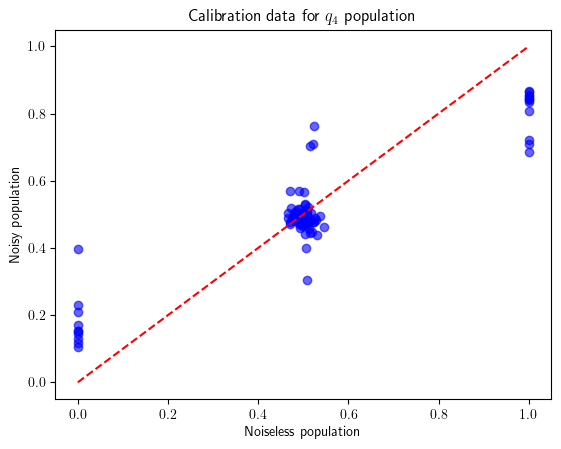

Learned correction model: y = (0.7267 ± 0.0317 )x + (0.1215 ± 0.0165)
$R^2$ score: 0.8427
1/5 done!


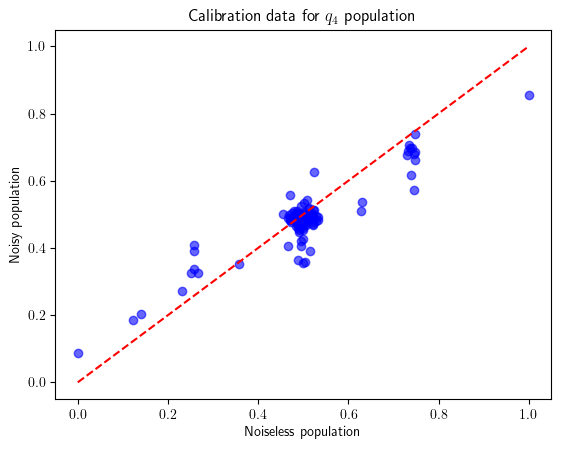

Learned correction model: y = (0.7372 ± 0.0225 )x + (0.1301 ± 0.0114)
$R^2$ score: 0.9160
2/5 done!


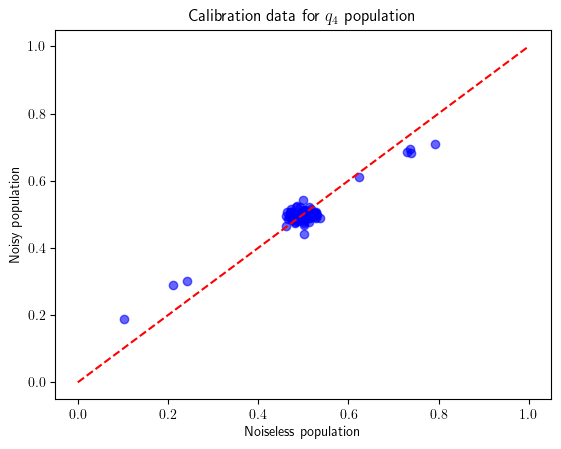

Learned correction model: y = (0.7812 ± 0.0235 )x + (0.1070 ± 0.0118)
$R^2$ score: 0.9187
3/5 done!


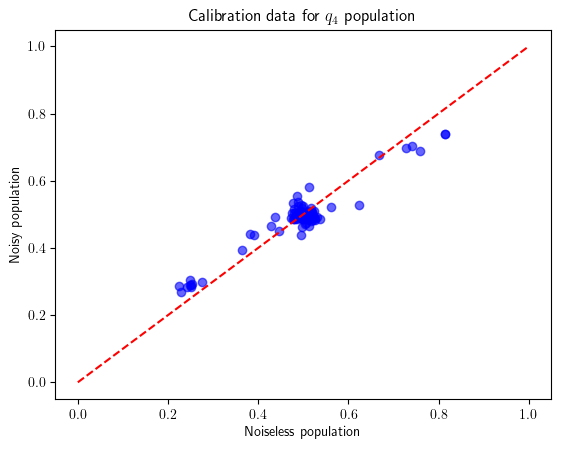

Learned correction model: y = (0.8080 ± 0.0166 )x + (0.0929 ± 0.0082)
$R^2$ score: 0.9601
4/5 done!


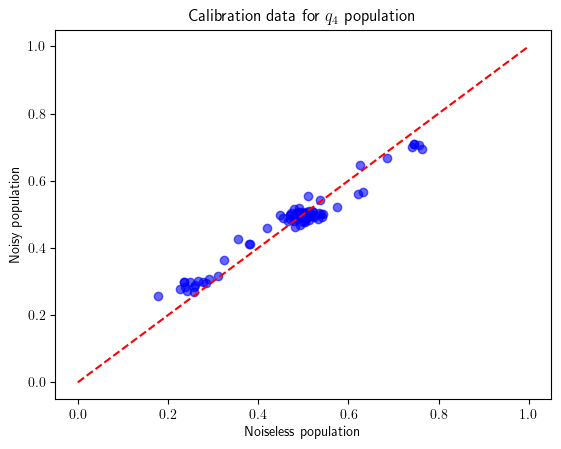

In [ ]:
with open("[RD]5_emitters.json", "r") as f:
    raw_data = json.load(f)
with open("[NTD]5_emitters.json", "r") as f:
    noisy_training_data = json.load(f)
with open("[ITD]5_emitters.json", "r") as f:
    ideal_training_data = json.load(f)

target_qubit = '4'
predicted_data = []
for idx, instant in enumerate(t):
    model, delta_a, delta_b, r2 = train_model(ideal_training_data[target_qubit][idx], noisy_training_data[target_qubit][idx])
    plt.scatter(ideal_training_data[target_qubit][idx], noisy_training_data[target_qubit][idx], color='blue', alpha=0.6, label="Noisy vs Noiseless")
    plt.plot([0, 1], [0, 1], 'r--', label="Ideal (y=x)")
    plt.xlabel("Noiseless population")
    plt.ylabel("Noisy population")
    plt.title(f"Calibration data for $q_{int(target_qubit)}$ population")
    predicted_data.append(correct_observable(raw_data[target_qubit][idx], model))
    print(f'{idx}/{len(t)} done!')
    plt.show()

In [47]:
corrected_data = { str(i) : [] for i in range(num_emitters) }
for qubit in corrected_data.keys():
    data = []
    print(f'Correcting qubit {(int(qubit))}')
    for idx, instant in enumerate(t):
        model, delta_a, delta_b, r2 = train_model(ideal_training_data[qubit][idx], noisy_training_data[qubit][idx])
        data.append(correct_observable(raw_data[qubit][idx], model))
        print(f'{idx}/{len(t)} done!')
    corrected_data[qubit] = data

Correcting qubit 0
Learned correction model: y = (0.8113 ± 0.0070 )x + (0.0851 ± 0.0040)
$R^2$ score: 0.9928
0/5 done!
Learned correction model: y = (0.7993 ± 0.0101 )x + (0.0931 ± 0.0054)
$R^2$ score: 0.9845
1/5 done!
Learned correction model: y = (0.7853 ± 0.0197 )x + (0.1010 ± 0.0100)
$R^2$ score: 0.9419
2/5 done!
Learned correction model: y = (0.7996 ± 0.0152 )x + (0.0964 ± 0.0078)
$R^2$ score: 0.9659
3/5 done!
Learned correction model: y = (0.8376 ± 0.0122 )x + (0.0770 ± 0.0062)
$R^2$ score: 0.9798
4/5 done!
Correcting qubit 1
Learned correction model: y = (0.6811 ± 0.0145 )x + (0.1589 ± 0.0078)
$R^2$ score: 0.9575
0/5 done!
Learned correction model: y = (0.7660 ± 0.0231 )x + (0.1175 ± 0.0117)
$R^2$ score: 0.9180
1/5 done!
Learned correction model: y = (0.7711 ± 0.0163 )x + (0.1212 ± 0.0086)
$R^2$ score: 0.9581
2/5 done!
Learned correction model: y = (0.8198 ± 0.0164 )x + (0.0891 ± 0.0084)
$R^2$ score: 0.9622
3/5 done!
Learned correction model: y = (0.8450 ± 0.0134 )x + (0.0801 ± 

Try plotting all of em together (using the same colors per qubit, just different markers)

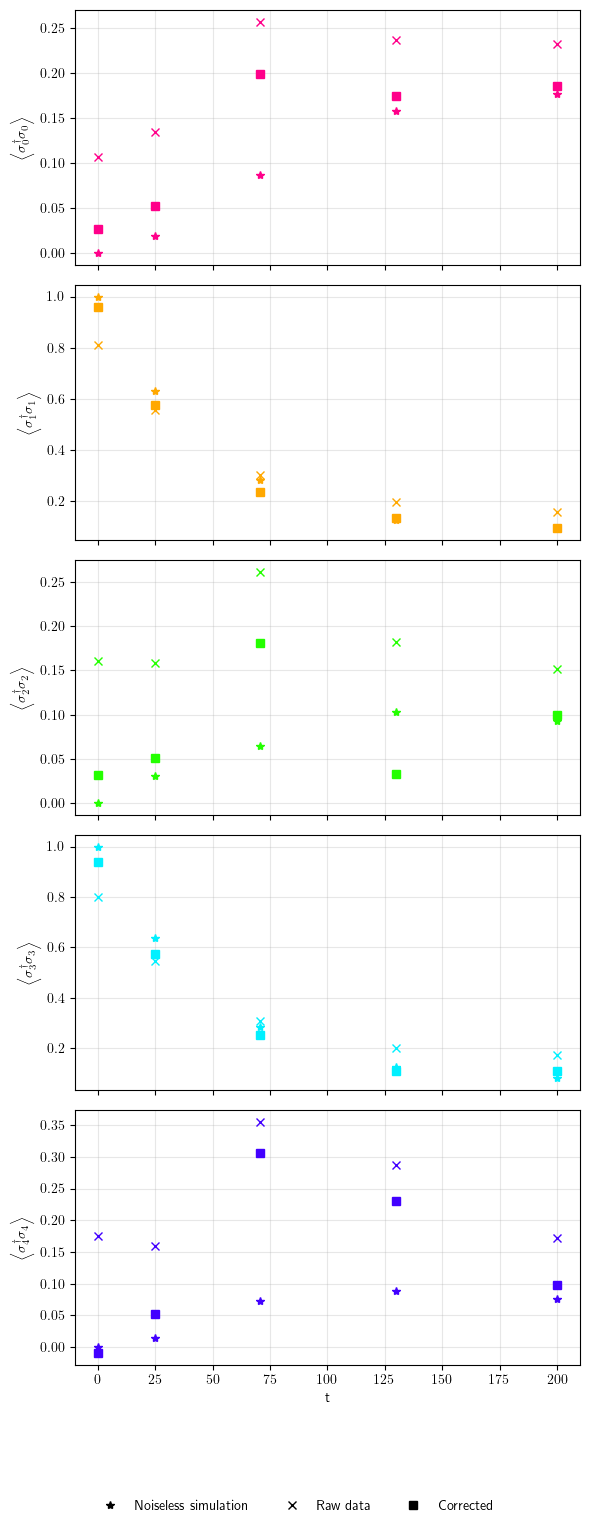

In [54]:
colors = generate_complementary_colors(num_emitters, 'neon', 'deeppink')
fig, axes = plt.subplots(num_emitters, 1, figsize=(6, 3*num_emitters), sharex=True)

if num_emitters == 1:
    axes = [axes]  # ensure it's iterable

for i, qubit in enumerate(corrected_data.keys()):
    ax = axes[i]
    color = colors[int(qubit)]

    ax.plot(t, ideal_evs[qubit], linestyle='none', marker='*', color=color)
    ax.plot(t, raw_data[qubit], linestyle='none', marker='x', color=color)
    ax.plot(t, corrected_data[qubit], linestyle='none', marker='s', color=color)
    ax.plot(np.nan, np.nan, linestyle='solid', color=color)

    ax.set_ylabel(f'$\\left< \\sigma^{{\\dagger}}_{int(qubit)} \\sigma_{int(qubit)} \\right>$')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('t')

handles, labels = axes[0].get_legend_handles_labels()
handles += [
    plt.Line2D([], [], linestyle='none', marker='*', color='black', label='Noiseless simulation'),
    plt.Line2D([], [], linestyle='none', marker='x', color='black', label='Raw data'),
    plt.Line2D([], [], linestyle='none', marker='s', color='black', label='Corrected')
]

fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('all_corrected_population.png', bbox_inches='tight')
plt.show()


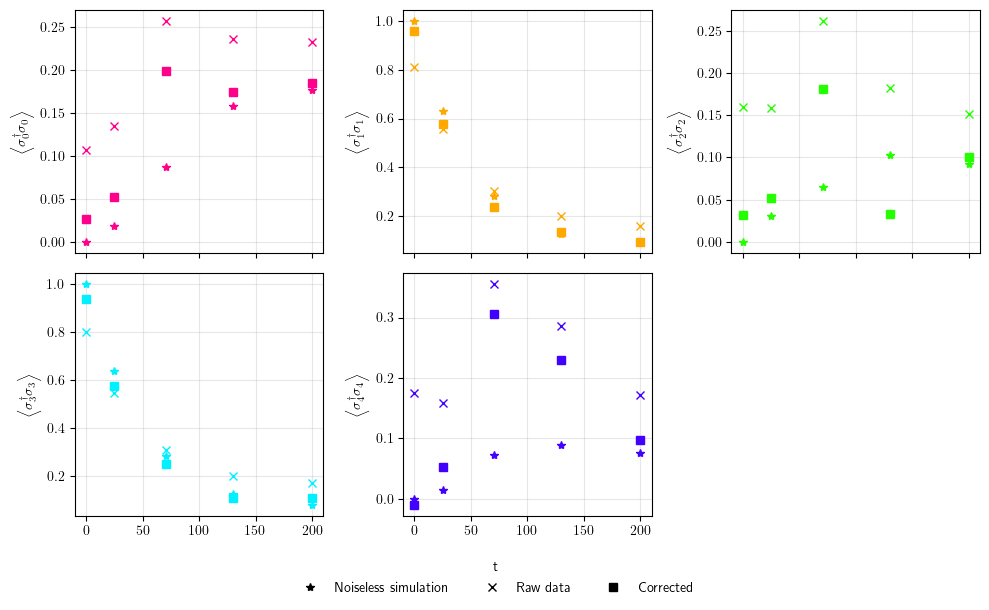

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Example setup
colors = generate_complementary_colors(num_emitters, 'neon', 'deeppink')

num_qubits = len(corrected_data.keys())
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)

axes = axes.flatten()  

# Plot each qubit
for i, qubit in enumerate(corrected_data.keys()):
    ax = axes[i]
    color = colors[int(qubit)]

    ax.plot(t, ideal_evs[qubit], linestyle='none', marker='*', color=color)
    ax.plot(t, raw_data[qubit], linestyle='none', marker='x', color=color)
    ax.plot(t, corrected_data[qubit], linestyle='none', marker='s', color=color)
    ax.plot(np.nan, np.nan, linestyle='solid', color=color)

    #ax.set_title(f'$q_{int(qubit)}$', fontsize=10)
    ax.set_ylabel(f'$\\left< \\sigma^{{\\dagger}}_{int(qubit)} \\sigma_{int(qubit)} \\right>$')
    ax.grid(True, alpha=0.3)

# Hide the extra subplot (the 6th one)
if num_qubits < len(axes):
    for j in range(num_qubits, len(axes)):
        fig.delaxes(axes[j])  # completely remove the unused subplot

# Shared x label
fig.text(0.5, 0.04, 't', ha='center')

handles = [
    plt.Line2D([], [], linestyle='none', marker='*', color='black', label='Noiseless simulation'),
    plt.Line2D([], [], linestyle='none', marker='x', color='black', label='Raw data'),
    plt.Line2D([], [], linestyle='none', marker='s', color='black', label='Corrected')
]

fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig('all_corrected_population_uneven.png', bbox_inches='tight')
plt.show()


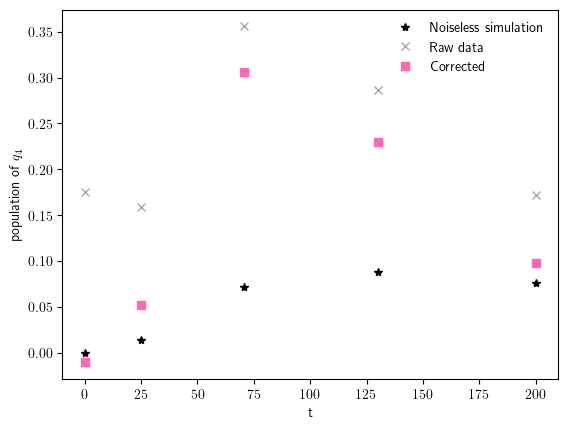

In [46]:
plt.plot(t, ideal_evs[target_qubit], linestyle = 'none', marker = '*', color = 'black', label = 'Noiseless simulation')
plt.plot(t, raw_data[target_qubit], linestyle = 'none', color = 'darkgrey', marker = 'x', label = 'Raw data')
plt.plot(t, predicted_data, linestyle = 'none', color = 'hotpink', marker = 's', label = 'Corrected')
plt.xlabel('t')
plt.ylabel(f'population of $q_{int(target_qubit)}$')
plt.legend(frameon = False)
plt.savefig('corrected_population_q4', bbox_inches = 'tight')
plt.show()